Running a simulation with SHyFT
=========

### This notebook is guiding through the simulation process of a catchment. The following steps are described:
1. **Loading required python modules and setting path to SHyFT installation**
2. **Configuration of a SHyFT simulation**
3. **Running a SHyFT simulation**
4. **Post-processing:** Fetching simulation results from the simulator-object.

### 1. Loading required python modules and setting path to SHyFT installation

In [1]:
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%pylab inline
import os
from os import path
import sys
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# set the path for your shyft build
# this should point to the directory that is created
# when you clone shyft, assuming you have built shyft
# there and not installed it to your system python
shyft_path = os.path.abspath("../../../shyft")
sys.path.insert(0, shyft_path)

# you could achieve the same by setting a PYTHONPATH

In [3]:
# once the shyft_path is set correctly, you should be able to import shyft modules
import shyft
from shyft import shyftdata_dir

# if you have problems here, it may be related to having your LD_LIBRARY_PATH
# pointing to the appropriate libboost_python libraries (.so files)
from shyft.repository.default_state_repository import DefaultStateRepository
from shyft.orchestration.configuration import yaml_configs
from shyft.orchestration.simulators.config_simulator import ConfigSimulator
from shyft import api

In [4]:
# now you can access the api of shyft with tab completion and help, try this:

#help(api.GeoPoint) # remove the hashtag and run the cell to print the documentation of the api.GeoPoint class
#api. # remove the hashtag, set the pointer behind the dot and use 
      # tab completion to see the available attributes of the shyft api

###2. Configuration of a SHyFT simulation

In [5]:
# set up configuration using *.yaml configuration files
# here is the *.yaml file that configures the simulation:
config_file_path = os.path.abspath("./nea-config/neanidelva_simulation.yaml")

# and here we pass it to the configurator, together with the name of the region 
# stated in the simulation.yaml file (here: "neanidelva") which we would like to run
cfg = yaml_configs.YAMLSimConfig(config_file_path, "neanidelva")

In [6]:
# Once we have all the configuration in place (read in from the .yaml files)
# we can start to do the simulation. Here we use the ConfigSimulator class 
# to initialize a simulator-object. Shyft has several ways to achieve this
# but the .yaml configs are the most straight forward

simulator = ConfigSimulator(cfg)

In [7]:
# Now the simulator is ready to run! You can explore this object with tab
# completion. As an example, you can see here how to get the number of cells
# in the region that was set up. This is used later for extracting the data.

n_cells = simulator.region_model.size()

In [8]:
# We need to instantiate a state_repos repository from the DefaultStateRepository class
# this will be used to provide initial values for the state variables of the simulation
state_repos = DefaultStateRepository(simulator.region_model.__class__, n_cells)

###3. Running a SHyFT simulation

In [9]:
# To run a simulation, we need a time_axis (length of the simulation), and
# an initial state. We get the time_axis from the cfg object (which takes it
# from the .yaml files) and the state we constructed above.

simulator.run(cfg.time_axis, state_repos.get_state(0))

### 4. Post processing
####Examples for fetching data

####a) Get the discharge for each (sub-) catchment

In [10]:
# Here we are going to extact data from the simulator object.
# We start by creating a list to hold discharge for each of the subcatchments.
# Then we'll get the data from the simulator object

# list for discharge time series for all subcatchments
discharge_ts = [] 

# mapping of internal catch ID to catchment
catchment_id_map = simulator.region_model.catchment_id_map 
# loop over each catchment, and extract the data
for cid in catchment_id_map:
    disch = simulator.region_model.statistics.discharge([int(cid)])
    # discharge is a TS object, and we have to use it's .v attribute
    # to extract the data vector 
    discharge_ts.append(disch.values)
    
sim_times = [disch.time(i) for i in range(disch.size())] # extracting time stamps
sim_dates = [datetime.datetime.utcfromtimestamp(t) for t in sim_times] # converting timestamps to datetime-objects

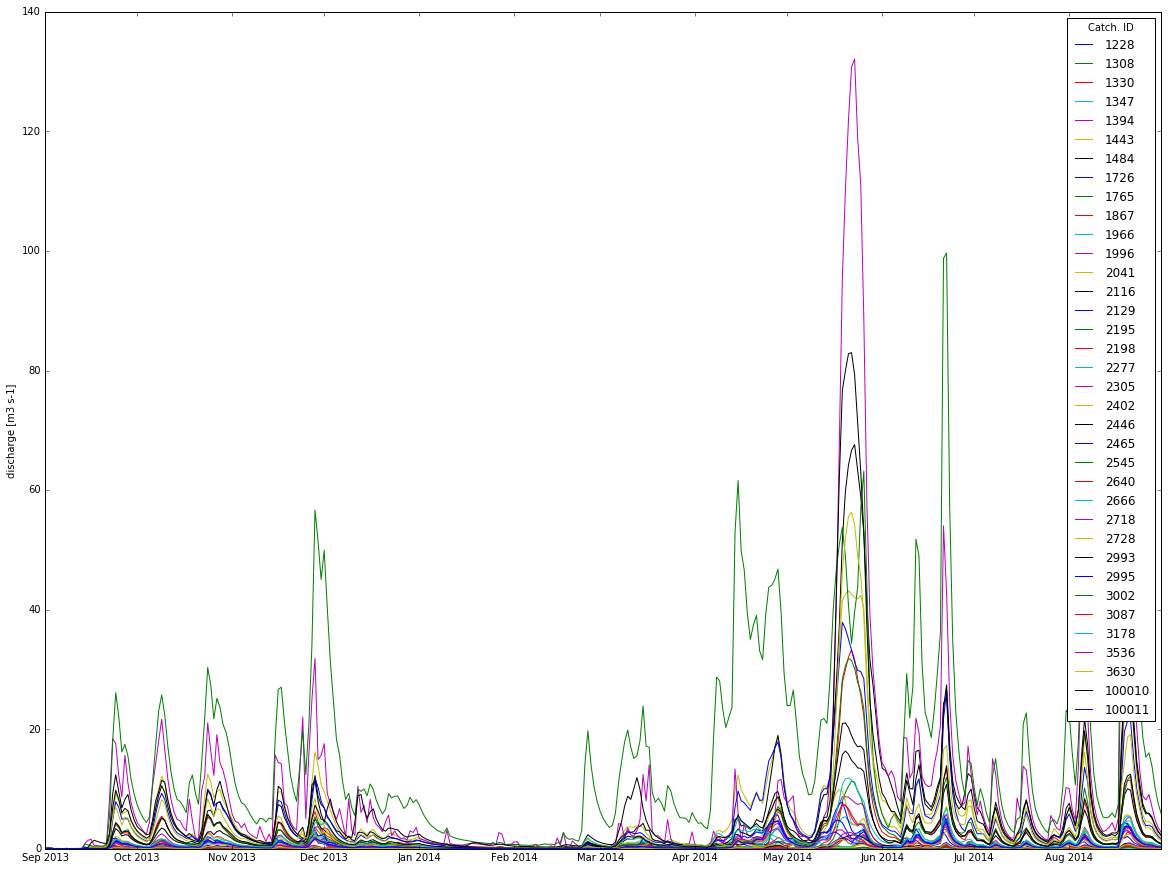

In [11]:
# We can make a quick plot of the data of each sub-catchment
fig, ax = plt.subplots(figsize=(20,15))

# plot each catchment discharge in the catchment_id_map
for i,d in enumerate(discharge_ts):
    ax.plot(sim_dates, d, label = "{}".format(catchment_id_map[i]))

ax.legend(title="Catch. ID")
ax.set_ylabel("discharge [m3 s-1]")

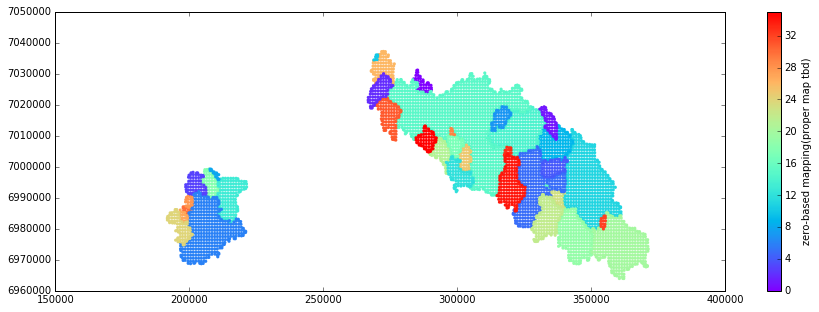

In [12]:
# If we're interested to look at values of individual cells, rather
# than at the catchment level, we can do that also. Shyft does not have
# an underlying 'raster' model, so you need to fetch all cells directlry
# from the simulator object
cells = simulator.region_model.get_cells()

# Once we have the cells, we can get their coordinate information
# and fetch the x- and y-location of the cells
x = [cell.geo.mid_point().x for cell in cells]
y = [cell.geo.mid_point().y for cell in cells]


# If you want to know the membership to each catchment
# of the cells, you can get a list of catchment ids for each cell
cid_z_map = dict([ (catchment_id_map[i],i) for i in range(len(catchment_id_map))])
catch_ids = np.array([cid_z_map[cell.geo.catchment_id()] for cell in cells])

# and make a quick catchment map...
# using a scatter plot of the cells
fig, ax = plt.subplots(figsize=(15,5))
cm = plt.cm.get_cmap('rainbow')
plot = ax.scatter(x, y, c=catch_ids, marker='.', s=40, lw=0, cmap=cm)
plt.colorbar(plot).set_label('zero-based mapping(proper map tbd)')

####b) Get the Snow Cover Fraction (SCF) of all cells for a certain point in time

In [13]:

# Here we'll do some more work to look at the timeseries data in each of the cells
# This example is collecting the response variable (here the SCF)
# for each of the cells for a certain point of time.
# set a date: year, month, day, (hour of day if hourly time step)
date = datetime.datetime(2014,5,15) 

try:
    idx = sim_dates.index(date) # index of date on time-axis
except:
    print("Date out of range, setting index to 0")
    idx = 0

# fetching SCF (the response variable is named "snow_sca")
# You can use tab-completion to explore the `rc`, short for "response collector"
# object of the cell, to see further response variables available.
scf = simulator.region_model.gamma_snow_response.sca([],idx)

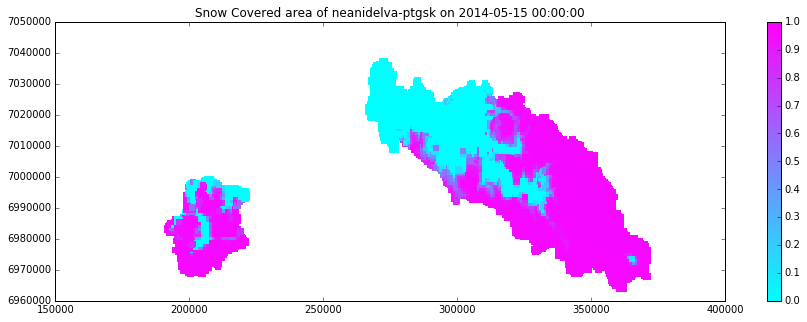

In [14]:
# And finally we can make a simple scatter plot for quick visualization
fig, ax = plt.subplots(figsize=(15,5))
cm = plt.cm.get_cmap('cool')
plot = ax.scatter(x, y, c=scf, vmin=0, vmax=1, marker='s', s=40, lw=0, cmap=cm)
plt.colorbar(plot)
plt.title('Snow Covered area of {0} on {1}'.format(simulator.config.region_model_id, date))


In [ ]:
# And let's compute histogram of the snow covered area as well
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(scf, bins=20, range=(0,1), color='r', alpha=0.5)
ax.set_xlabel("SCF of grid cell")
ax.set_ylabel("frequency")